In [4]:
import cupy as np
import matplotlib.pyplot as plt
import pandas as pd

In [5]:
df_train = pd.read_csv(r"E:\Projects\mnist_train.csv")
x_train = df_train.drop(columns=['5'])
y_train = df_train['5']

In [6]:
df_test = pd.read_csv(r"E:\Projects\mnist_test.csv")
x_test = df_test.drop(columns=['7'])
y_test = df_test['7']

In [7]:
def visualize_digit(image, label=None):

    plt.figure(figsize=(5, 5))
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    if label is not None:
        plt.title(f'Label: {label}')
    
    plt.show()

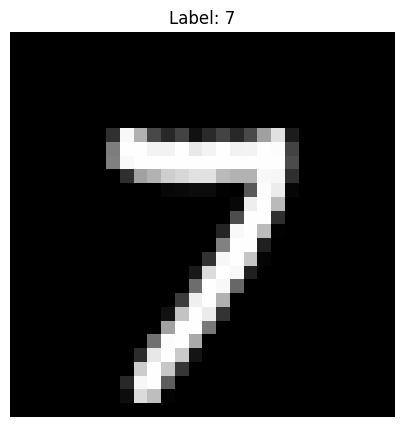

In [8]:
index = 59197 
image = x_train.iloc[index].values.reshape(28, 28)
visualize_digit(image, y_train.iloc[index])

In [9]:
x_train = x_train[:60000]
y_train = y_train[:60000]

In [10]:
x_train = np.asarray(x_train)  # Convert to CuPy array
y_train = np.asarray(y_train)  # Convert to CuPy array

In [11]:
original_x_train = x_train
original_y_train = y_train


<div class="alert alert-block ">
Data augmentation


</div>

In [15]:
import cupy as cp
import scipy.ndimage

def augment_data(images):
    augmented_images = []
    for img in images:
        # Convert CuPy array to NumPy and reshape to 28x28
        img_np = img.get().reshape(28, 28)
        
        # Generate augmentation parameters as Python floats
        angle = float(cp.random.uniform(-10, 10))
        shift_x = float(cp.random.uniform(-2, 2))
        shift_y = float(cp.random.uniform(-2, 2))
        
        # Apply rotation and shifting using SciPy (which works with NumPy arrays)
        rotated = scipy.ndimage.rotate(img_np, angle, reshape=False, mode='constant', cval=0)
        shifted = scipy.ndimage.shift(rotated, shift=[shift_x, shift_y], mode='constant', cval=0)
        
        # Convert back to CuPy array and add noise
        augmented = cp.asarray(shifted) + cp.random.normal(0, 0.02, (28, 28))
        augmented = cp.clip(augmented, 0, 1)
        
        # Flatten to original shape (e.g., 784)
        augmented_images.append(augmented.flatten())
    
    return cp.array(augmented_images)

# Example usage:
# x_train_augmented = augment_data(x_train)


In [16]:
x_train = augment_data(x_train)


<div class="alert alert-block alert-success">
<b>Beginning of Neural Network</b>
</div>

<div class="alert alert-block ">
Initial layer

</div>

In [17]:
class layer_dense:
    def __init__(self , n_inputs , n_neurons):
        self.n_inputs = n_inputs
        self.n_neurons = n_neurons

        self.weights = np.random.randn(n_inputs , n_neurons)*0.01
        self.biases = np.zeros((1,n_neurons))

    def forward(self, inputs):
        self.inputs = inputs
        #calculating the dot product basically X.W + b
        self.outputs = np.dot(inputs, self.weights) + self.biases
#dvalues = dl_dz
    def backward(self , dvalues):
        self.dvalues = dvalues
        
        #gradient on weight and bias parameter
        self.dweights = np.dot(self.inputs.T , dvalues)
        self.dbiases = np.sum(dvalues , axis=0 , keepdims=True)

        #gradient on input values
        self.dinputs = np.dot(dvalues , self.weights.T)



<div class="alert alert-block ">
ReLU activation 

</div>

In [18]:
class relu:
    def forward(self , inputs):
        self.inputs = inputs
        self.outputs = np.maximum(0 , inputs)

    def backward(self , dvalues):
        #making the copies
        self.dinputs = dvalues.copy()
        # zero gradient where input values are negative
        self.dinputs[self.inputs <=0] = 0

<div class="alert alert-block ">
Softmax activation

</div>

In [19]:
class activation_softmax:
    def forward(self , inputs):
        exp_values = np.exp(inputs - np.max(inputs , axis = 1 ,keepdims=True))
        # keepdims = True for broadcasting
        probabilities = exp_values/(np.sum(exp_values , axis=1 , keepdims=True))

        self.outputs = probabilities

<div class="alert alert-block ">
Loss Class

</div>

In [20]:
# common loss class
class loss:
    #calculates the data and regularization losses , given the ground truth and predicted values
    def calculate(self , outputs , y):
        sample_loss = self.forward(outputs , y)
        data_loss = np.mean(sample_loss)

        return data_loss

<div class="alert alert-block ">
Categorical Cross Entropy Loss

</div>

In [21]:
class loss_categorical_cross_entropy(loss):

    def forward(self , y_pred , y_true ):
        samples = len(y_pred)

        #clipping the data to prevent division by 0 
        # and preventing giant values

        y_pred_clipped = np.clip(y_pred , 1e-7 , 1-1e-7)

        #probabilities for target values - 
        #only if categorical labels
        #applying advanced indexing
        if len(y_true.shape) == 1:
            correct_confidences = y_pred_clipped[
                range(samples),
                y_true
            ]

        # mask values - only for one-hot encoded labels
        elif len(y_true.shape) == 2:
            correct_confidences = np.sum(
                y_pred_clipped * y_true,
                axis=1 #making it to multiply just along the rows
            )

        negative_log_likelihood = -np.log(correct_confidences)
        return negative_log_likelihood
    
    #backward pass
    def backward(self , dvalues , y_true):

        #number of samples
        samples = len(dvalues)
        
        #number of labels in every sample will be calculated using the 1st sample
        labels = len(dvalues[0])

        #if labels are sparse , turning them into one hot vector
        if len(y_true.shape) == 1:
            y_true = np.eye(labels)[y_true]

        #calculating the gradient
        self.dinputs = -y_true / dvalues
        self.dinputs = self.dinputs / samples

<div class="alert alert-block ">
combined softmax activation and categorical cross entropy for last layer : Forward and Backward pass

</div>

In [22]:
#softmax and cross entropy loss are brought together
# in the single following class for faster backward step

class activation_softmax_loss_categorical_cross_entropy:

    def __init__(self):
        self.activation = activation_softmax()
        self.loss = loss_categorical_cross_entropy()

    #forward pass
    def forward(self , inputs , y_true):
        self.activation.forward(inputs)
        self.outputs = self.activation.outputs
        return self.loss.calculate(self.outputs , y_true)
    
    # backward pass
    def backward(self , dvalues , y_true):
        samples = len(dvalues)
        #if lables are one-hot encoded,
        #turn them to discrete values

        if len(y_true.shape) == 2:
            y_true = np.argmax(y_true , axis = 1)

        #copying in order to modify safely
        self.dinputs = dvalues.copy()
        #calculate gradients
        self.dinputs[range(samples), y_true] -= 1
        #normalize the gradient
        self.dinputs = self.dinputs / samples

<div class="alert alert-block ">
Batch Normalization

</div>

In [26]:
class BatchNormalization:
    def __init__(self, size, momentum=0.9, epsilon=1e-5):
        self.gamma = cp.ones((1, size))
        self.beta = cp.zeros((1, size))
        self.momentum = momentum
        self.epsilon = epsilon
        self.running_mean = cp.zeros((1, size))
        self.running_var = cp.ones((1, size))

    def forward(self, X, training=True):
        self.X = X  # Store input for backpropagation
        if training:
            batch_mean = cp.mean(X, axis=0, keepdims=True)
            batch_var = cp.var(X, axis=0, keepdims=True)
            self.X_normalized = (X - batch_mean) / cp.sqrt(batch_var + self.epsilon)
            self.outputs = self.gamma * self.X_normalized + self.beta

            # Update running stats
            self.running_mean = self.momentum * self.running_mean + (1 - self.momentum) * batch_mean
            self.running_var = self.momentum * self.running_var + (1 - self.momentum) * batch_var
        else:
            self.X_normalized = (X - self.running_mean) / cp.sqrt(self.running_var + self.epsilon)
            self.outputs = self.gamma * self.X_normalized + self.beta
        
        return self.outputs

    def backward(self, dinputs):
        batch_size = self.X.shape[0]

        dgamma = cp.sum(dinputs * self.X_normalized, axis=0, keepdims=True)
        dbeta = cp.sum(dinputs, axis=0, keepdims=True)

        dX_normalized = dinputs * self.gamma
        dvar = cp.sum(dX_normalized * (self.X - self.running_mean) * -0.5 * cp.power(self.running_var + self.epsilon, -1.5), axis=0, keepdims=True)
        dmean = cp.sum(dX_normalized * -1 / cp.sqrt(self.running_var + self.epsilon), axis=0, keepdims=True) + dvar * cp.mean(-2 * (self.X - self.running_mean), axis=0, keepdims=True)

        self.dinputs = dX_normalized / cp.sqrt(self.running_var + self.epsilon) + dvar * 2 * (self.X - self.running_mean) / batch_size + dmean / batch_size
        self.dgamma = dgamma
        self.dbeta = dbeta


<div class="alert alert-block ">
using optimizer as adam

</div>

In [31]:


# Adam optimizer
class Optimizer_Adam:
    # Initialize optimizer - set settings
    def __init__(self, learning_rate=0.001, decay=0., epsilon=1e-7, beta1=0.9, beta2=0.999):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon
        self.beta1 = beta1
        self.beta2 = beta2


    # Call once before any parameter updates
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * (1. / (1. + self.decay * self.iterations))

    # Update parameters
    def update_params(self, layer):
        if hasattr(layer, 'weights'):  # Standard Dense Layer
            if not hasattr(layer, 'weight_cache'):
                layer.weight_momentums = np.zeros_like(layer.weights)
                layer.weight_cache = np.zeros_like(layer.weights)
                layer.bias_momentums = np.zeros_like(layer.biases)
                layer.bias_cache = np.zeros_like(layer.biases)

        # Update weights
            layer.weight_momentums = self.beta1 * layer.weight_momentums + (1 - self.beta1) * layer.dweights
            weight_momentums_corrected = layer.weight_momentums / (1 - self.beta1 ** (self.iterations + 1))
            layer.weight_cache = self.beta2 * layer.weight_cache + (1 - self.beta2) * layer.dweights**2
            weight_cache_corrected = layer.weight_cache / (1 - self.beta2 ** (self.iterations + 1))
            layer.weights += -self.current_learning_rate * weight_momentums_corrected / (np.sqrt(weight_cache_corrected) + self.epsilon)

        # Update biases
            layer.bias_momentums = self.beta1 * layer.bias_momentums + (1 - self.beta1) * layer.dbiases
            bias_momentums_corrected = layer.bias_momentums / (1 - self.beta1 ** (self.iterations + 1))
            layer.bias_cache = self.beta2 * layer.bias_cache + (1 - self.beta2) * layer.dbiases**2
            bias_cache_corrected = layer.bias_cache / (1 - self.beta2 ** (self.iterations + 1))
            layer.biases += -self.current_learning_rate * bias_momentums_corrected / (np.sqrt(bias_cache_corrected) + self.epsilon)

        elif hasattr(layer, 'gamma'):  # BatchNorm Layer
            if not hasattr(layer, 'gamma_cache'):
                layer.gamma_momentums = np.zeros_like(layer.gamma)
                layer.gamma_cache = np.zeros_like(layer.gamma)
                layer.beta_momentums = np.zeros_like(layer.beta)
                layer.beta_cache = np.zeros_like(layer.beta)

        # Update gamma
            layer.gamma_momentums = self.beta1 * layer.gamma_momentums + (1 - self.beta1) * layer.dgamma
            gamma_momentums_corrected = layer.gamma_momentums / (1 - self.beta1 ** (self.iterations + 1))
            layer.gamma_cache = self.beta2 * layer.gamma_cache + (1 - self.beta2) * layer.dgamma**2
            gamma_cache_corrected = layer.gamma_cache / (1 - self.beta2 ** (self.iterations + 1))
            layer.gamma += -self.current_learning_rate * gamma_momentums_corrected / (np.sqrt(gamma_cache_corrected) + self.epsilon)

        # Update beta
            layer.beta_momentums = self.beta1 * layer.beta_momentums + (1 - self.beta1) * layer.dbeta
            beta_momentums_corrected = layer.beta_momentums / (1 - self.beta1 ** (self.iterations + 1))
            layer.beta_cache = self.beta2 * layer.beta_cache + (1 - self.beta2) * layer.dbeta**2
            beta_cache_corrected = layer.beta_cache / (1 - self.beta2 ** (self.iterations + 1))
            layer.beta += -self.current_learning_rate * beta_momentums_corrected / (np.sqrt(beta_cache_corrected) + self.epsilon)

    # Call once after any parameter updates
    def post_update_params(self):
        self.iterations += 1


<div class="alert alert-block ">
Vanilla SGD

</div>

In [32]:


class Optimizer_SGD:
    # Initialize optimizer - set settings,
    # learning rate of 1. is default for this optimizer
    def __init__(self, learning_rate=0.01, decay=0., momentum=0.):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.momentum = momentum

    # Call once before any parameter updates
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * \
                (1. / (1. + self.decay * self.iterations))

    # Update parameters
    def update_params(self, layer):
        # If we use momentum
        if self.momentum:
            # If layer does not contain momentum arrays, create them
            # filled with zeros
            if not hasattr(layer, 'weight_momentums'):
                layer.weight_momentums = np.zeros_like(layer.weights)
                layer.bias_momentums = np.zeros_like(layer.biases)

            # Build weight updates with momentum - take previous
            # updates multiplied by retain factor and update with
            # current gradients
            weight_updates = self.momentum * layer.weight_momentums - \
                             self.current_learning_rate * layer.dweights
            layer.weight_momentums = weight_updates

            # Build bias updates
            bias_updates = self.momentum * layer.bias_momentums - \
                           self.current_learning_rate * layer.dbiases
            layer.bias_momentums = bias_updates

        # Vanilla SGD updates (as before momentum update)
        else:
            weight_updates = -self.current_learning_rate * layer.dweights
            bias_updates = -self.current_learning_rate * layer.dbiases

        # Update weights and biases using either
        # vanilla or momentum updates
        layer.weights += weight_updates
        layer.biases += bias_updates

    # Call once after any parameter updates
    def post_update_params(self):
        self.iterations += 1


<div class="alert alert-block ">
Droput method

</div>

In [33]:
class Dropout:
    def __init__(self, rate=0.3):

        # Dropout rate
        self.rate = rate
        
        # Mask to track which neurons are kept/dropped
        self.mask = None
        
        # Binary scale for maintaining expected output during inference
        self.scale = 1 / (1 - rate)
        
    def forward(self, inputs, training=True):

        # Store inputs for backward pass
        self.inputs = inputs
        
        # During training, randomly drop neurons
        if training:
            # Create a mask of same shape as inputs
            self.mask = np.random.rand(*inputs.shape) > self.rate
            
            # Scale and apply mask
            self.outputs = inputs * self.mask * self.scale
        else:
            # During inference, no dropout
            self.outputs = inputs
        
        return self.outputs
    
    def backward(self, dvalues):

        # During backward pass, apply the same mask
        self.dinputs = dvalues * self.mask * self.scale
        
        return self.dinputs

<div class="alert alert-block ">
Training the neural network

</div>

In [34]:
# Creating the dense layer with 28*28 inputs
dense1 = layer_dense(784, 784)
batchnorm1 = BatchNormalization(784)  # BatchNorm after first dense
activation1 = relu()
dropout1 = Dropout(rate=0.3)

dense2 = layer_dense(784, 784)
batchnorm2 = BatchNormalization(784)  # BatchNorm after second dense
activation2 = relu()
dropout2 = Dropout(rate=0.3)

dense3 = layer_dense(784, 10)

# Softmax loss activation
loss_activation = activation_softmax_loss_categorical_cross_entropy()

# Optimizer
optimizer = Optimizer_Adam(learning_rate=0.001, decay=1e-4)

# Training loop
for epoch in range(100):
    # Forward pass
    dense1.forward(x_train)
    batchnorm1.forward(dense1.outputs, training=True)  # Apply Batch Norm
    activation1.forward(batchnorm1.outputs)
    dropout1.forward(activation1.outputs, training=True)

    dense2.forward(dropout1.outputs)
    batchnorm2.forward(dense2.outputs, training=True)  # Apply Batch Norm
    activation2.forward(batchnorm2.outputs)
    dropout2.forward(activation2.outputs, training=True)

    dense3.forward(dropout2.outputs)

    # Compute loss
    loss = loss_activation.forward(dense3.outputs, y_train)

    # Calculate accuracy
    predictions = np.argmax(loss_activation.outputs, axis=1)
    if len(y_train.shape) == 2:
        y_train = np.argmax(y_train, axis=1)
    accuracy = np.mean(predictions == y_train)

    print(f'epoch: {epoch}, ' +
          f'acc: {accuracy:.3f}, ' +
          f'loss: {loss:.3f}, ' +
          f'lr: {optimizer.current_learning_rate}')

    # Backward pass
    loss_activation.backward(loss_activation.outputs, y_train)
    dense3.backward(loss_activation.dinputs)
    dropout2.backward(dense3.dinputs)
    activation2.backward(dropout2.dinputs)
    batchnorm2.backward(activation2.dinputs)  # Backpropagate through BatchNorm
    dense2.backward(batchnorm2.dinputs)

    dropout1.backward(dense2.dinputs)
    activation1.backward(dropout1.dinputs)
    batchnorm1.backward(activation1.dinputs)  # Backpropagate through BatchNorm
    dense1.backward(batchnorm1.dinputs)

    # Update parameters
    optimizer.pre_update_params()
    optimizer.update_params(dense1)

    optimizer.update_params(dense2)

    optimizer.update_params(dense3)
    optimizer.post_update_params()


epoch: 0, acc: 0.090, loss: 2.326, lr: 0.01
epoch: 1, acc: 0.268, loss: 2.463, lr: 0.01
epoch: 2, acc: 0.298, loss: 2.761, lr: 0.009999000099990002
epoch: 3, acc: 0.330, loss: 2.047, lr: 0.009998000399920017
epoch: 4, acc: 0.406, loss: 1.700, lr: 0.009997000899730081
epoch: 5, acc: 0.494, loss: 1.488, lr: 0.009996001599360257
epoch: 6, acc: 0.529, loss: 1.420, lr: 0.009995002498750625
epoch: 7, acc: 0.553, loss: 1.354, lr: 0.009994003597841295
epoch: 8, acc: 0.581, loss: 1.237, lr: 0.009993004896572401
epoch: 9, acc: 0.612, loss: 1.143, lr: 0.009992006394884094
epoch: 10, acc: 0.617, loss: 1.117, lr: 0.009991008092716556
epoch: 11, acc: 0.640, loss: 1.059, lr: 0.009990009990009992
epoch: 12, acc: 0.670, loss: 0.987, lr: 0.009989012086704625
epoch: 13, acc: 0.682, loss: 0.946, lr: 0.00998801438274071
epoch: 14, acc: 0.691, loss: 0.918, lr: 0.009987016878058523
epoch: 15, acc: 0.704, loss: 0.880, lr: 0.009986019572598362
epoch: 16, acc: 0.720, loss: 0.835, lr: 0.009985022466300548
epoch:

<div class="alert alert-block alert-success">
 Metric analysis

</div>

In [35]:
# Prepare test data (ensure it's in the right format)
x_test = np.asarray(x_test)
y_test = np.asarray(y_test)

# Perform forward pass through the network
def predict(X):
    # Forward pass through the first layer and ReLU
    dense1.forward(X)
    activation1.forward(dense1.outputs)
    dropout1.forward(activation1.outputs, training=False)  # Inference mode

    # Second layer and ReLU
    dense2.forward(dropout1.outputs)
    activation2.forward(dense2.outputs)
    dropout2.forward(activation2.outputs, training=False)  # Inference mode

    # Final layer with Softmax
    dense3.forward(dropout2.outputs)
    
    # Get predictions (class with highest probability)
    return np.argmax(dense3.outputs, axis=1)

# Perform prediction
predictions = predict(x_test)

# Calculate accuracy
if len(y_test.shape) == 2:
    y_test = np.argmax(y_test, axis=1)

accuracy = np.mean(predictions == y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Optional: Detailed classification report
from collections import Counter

# Confusion matrix
def confusion_matrix(true, pred):
    conf_matrix = np.zeros((10, 10), dtype=int)
    for t, p in zip(true, pred):
        conf_matrix[t, p] += 1
    return conf_matrix

# Create confusion matrix
conf_mat = confusion_matrix(y_test, predictions)

# Print confusion matrix
print("\nConfusion Matrix:")
print(conf_mat)

# Per-class accuracy
per_class_accuracy = conf_mat.diagonal() / conf_mat.sum(axis=1)
print("\nPer-class Accuracy:")
for digit, acc in enumerate(per_class_accuracy):
    print(f"Digit {digit}: {acc * 100:.2f}%")

# Misclassification analysis
misclassified_indices = np.where(predictions != y_test)[0]
print(f"\nTotal Misclassified Samples: {len(misclassified_indices)}")

# Optional: Visualize some misclassified samples
def visualize_misclassifications(x_test, y_test, predictions, num_to_show=5):
    misclassified_indices = np.where(predictions != y_test)[0]
    
    # Randomly select some misclassified samples
    show_indices = np.random.choice(misclassified_indices, 
                                    min(num_to_show, len(misclassified_indices)), 
                                    replace=False)
    
    for idx in show_indices:
        plt.figure(figsize=(5, 5))
        plt.imshow(x_test[idx].reshape(28, 28), cmap='gray')
        plt.title(f"True: {y_test[idx]}, Predicted: {predictions[idx]}")
        plt.axis('off')
        plt.show()

# Uncomment to visualize misclassifications
# visualize_misclassifications(x_test, y_test, predictions)

Test Accuracy: 54.13%

Confusion Matrix:
[[ 978    0    0    0    0    0    0    0    2    0]
 [   1 1027    0    3    0    0    0   11   93    0]
 [ 767    2   16    7    0    0    0   37  200    3]
 [  52    5    0  803    0    0    0   28   97   25]
 [ 221   38    0    0    1    0   17    1   30  674]
 [ 306    0    0   90    0    7    0    3  463   23]
 [ 759    5    0    0    0    0   48    0  145    1]
 [  89   15    0    2    0    0    0  895    6   20]
 [ 105   21    0    0    0    0    1    9  817   21]
 [ 139   26    0    3    0    0    0    9   12  820]]

Per-class Accuracy:
Digit 0: 99.80%
Digit 1: 90.48%
Digit 2: 1.55%
Digit 3: 79.50%
Digit 4: 0.10%
Digit 5: 0.78%
Digit 6: 5.01%
Digit 7: 87.15%
Digit 8: 83.88%
Digit 9: 81.27%

Total Misclassified Samples: 4587
